Repeat the same example as the earlier notebook, but use CNF construction with regularization, add NFE property too.

In [267]:
import os
import argparse
import glob
from PIL import Image
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import torch
import torch.nn as nn
import torch.optim as optim

from typing import Union, Callable
from torch.autograd import grad

import seaborn as sns

import six
import math

In [268]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)

In [269]:
device = torch.device('cuda:' + '0' if torch.cuda.is_available() else 'cpu')

In [270]:
parser = argparse.ArgumentParser()
parser.add_argument("--adjoint", action="store_false")

parser.add_argument('--l2int', 
                    type=float, 
                    default=0.1, 
                    help="int_t ||f||_2")
parser.add_argument('--JFrobint', 
                    type=float, 
                    default=0.1, 
                    help="int_t ||df/dx||_F")
parser.add_argument('--num_samples', type=int, default=1000, help="number of samples")

parser.add_argument('--l1int', type=float, default=None, help="int_t ||f||_1")
parser.add_argument('--dl2int', type=float, default=None, help="int_t ||f^T df/dt||_2")
parser.add_argument('--JdiagFrobint', type=float, default=None, help="int_t ||df_i/dx_i||_F")
parser.add_argument('--JoffdiagFrobint', type=float, default=None, help="int_t ||df/dx - df_i/dx_i||_F")

parser.add_argument('--niters', type=int, default=1200, help="number of iterations")
parser.add_argument('--use_reg', type=bool, default=True)

args = parser.parse_args(args=())

In [271]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [272]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [273]:
import reg_lib
import utils

In [274]:
REGULARIZATION_FNS = {
    "l1int": reg_lib.l1_regularzation_fn,
    "l2int": reg_lib.l2_regularzation_fn,
    "dl2int": reg_lib.directional_l2_regularization_fn,
    "JFrobint": reg_lib.jacobian_frobenius_regularization_fn,
    "JdiagFrobint": reg_lib.jacobian_diag_frobenius_regularization_fn,
    "JoffdiagFrobint": reg_lib.jacobian_offdiag_frobenius_regularization_fn,
}

INV_REGULARIZATION_FNS = {v: k for k, v in six.iteritems(REGULARIZATION_FNS)}

In [275]:
def append_regularization_to_log(log_message, regularization_fns, reg_states):
    for i, reg_fn in enumerate(regularization_fns):
        log_message = log_message + " | " + INV_REGULARIZATION_FNS[reg_fn] + ": {:.8f}".format(reg_states[i].item())
    return log_message


def create_regularization_fns(args):
    regularization_fns = []
    regularization_coeffs = []

    for arg_key, reg_fn in six.iteritems(REGULARIZATION_FNS):
        if getattr(args, arg_key) is not None:
            regularization_fns.append(reg_fn)
            regularization_coeffs.append(eval("args." + arg_key))

    regularization_fns = tuple(regularization_fns)
    regularization_coeffs = tuple(regularization_coeffs)
    return regularization_fns, regularization_coeffs

In [276]:
regularization_fns, regularization_coeffs = create_regularization_fns(args)

regularization_fns, regularization_coeffs

((<function reg_lib.l2_regularzation_fn(x, logp, dx, dlogp)>,
  <function reg_lib.jacobian_frobenius_regularization_fn(x, logp, dx, dlogp)>),
 (0.1, 0.1))

In [277]:
def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd"""
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[0][:, i]
    return trJ

def hutch_trace(x_out, x_in, noise=None, **kwargs):
    """Hutchinson's trace Jacobian estimator, O(1) call to autograd"""
    jvp = grad(x_out, x_in, noise, create_graph=True)[0]
    trJ = torch.einsum('bi,bi->b', jvp, noise)

    return trJ


def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()

In [278]:
noise_samples = torch.distributions.Normal(0, 1).sample((1000, 1))
noise_samples.shape

torch.Size([1000, 1])

In [279]:
def get_batch(num_samples):
     # Define the mean of each gaussian
    means = np.array([-3.5, 0.0, 3.5])
    # Define the weights for each gaussian
    weights = np.array([0.2, 0.2, 0.6])
    
    scales = np.array([1.5, 0.6, 0.6])
    
    weights /= np.sum(weights)
    # randomly choose a gaussian for each sample
    components = np.random.choice(means.size, size=num_samples, p=weights)
    # sample from the chosen gaussians
    points = np.random.normal(means[components], scales[components], size=num_samples)
    return torch.from_numpy(points).float().view(-1, 1).to(device), torch.zeros(num_samples, 1).type(torch.float32).to(device)

In [280]:
class ODEfunc(nn.Module):
    """
    Create an ODEfunc class where we take in dimension of input z as an argument and create a neural network with one hidden layer, and non-linear activation tanh between each linear layer. The output of the neural network is the derivative of z with respect to t, dz/dt.
    """
    def __init__(self, dim, hidden_dim, nonlinear=nn.ELU(inplace=True)):
        super(ODEfunc, self).__init__()
        self.nl = nonlinear
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        #         self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.nl(out)
        out = self.fc2(out)
        out = self.nl(out)
        #         out = self.fc3(out)
        #         out = self.nl(out)
        out = self.fc4(out)
        return out

In [281]:
class CNF_plain(nn.Module):
    """
    CNF without any regularization on the kinetic energy or the Jacobian. Trace estimator specifies whether to calculate exact trace or use Hutchinson's trace estimator.
    """
    def __init__(self, 
                 net:nn.Module, 
                 trace_estimator:Union[Callable, None]=None, 
                 noise_dist=None,
                #  integration_time=torch.Tensor([1, 0]).float()
                 ):
        super(CNF_plain, self).__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else trace_df_dz
        self.noise_dist = noise_dist

    @property
    def nfe(self):
        return self.net.nfe

    @nfe.setter
    def nfe(self, value):
        self.net.nfe = value


    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            dz_dt = self.net(t, z).view(batchsize, 1)
            
            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)

In [282]:
class CNF_regularized(nn.Module):
    """
    CNF with regularization on the kinetic energy or the Jacobian. for now we still use exact trace.
    """
    def __init__(self, 
                 net:nn.Module, 
                 trace_estimator:Union[Callable, None]=None, 
                 noise_dist=None,
                 ):
        super(CNF_regularized, self).__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else trace_df_dz
        self.noise_dist = noise_dist
        self.regularization_fns = regularization_fns

    @property
    def nfe(self):
        return self.net.nfe

    @nfe.setter
    def nfe(self, value):
        self.net.nfe = value

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            dz_dt = self.net(t, z).view(batchsize, 1)
            
            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

            reg_states = tuple(reg_fn(z, logp_z, dz_dt, dlogp_z_dt) for reg_fn in self.regularization_fns)

        return (dz_dt, dlogp_z_dt) + reg_states

In [283]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

We will test this on a 1D Gaussian distribution, see if the NFE works as expected. Then we will include regularization in an additional class.

In [284]:
my_net = ODEfunc(1, 32).to(device)
my_net

ODEfunc(
  (nl): ELU(alpha=1.0, inplace=True)
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

In [285]:
my_cnf_plain = CNF_plain(my_net).to(device)
my_cnf_reg = CNF_regularized(my_net).to(device)

In [286]:
for name, param in my_cnf_plain.named_parameters():
    print(name, param.shape)

net.fc1.weight torch.Size([32, 1])
net.fc1.bias torch.Size([32])
net.fc2.weight torch.Size([32, 32])
net.fc2.bias torch.Size([32])
net.fc4.weight torch.Size([1, 32])
net.fc4.bias torch.Size([1])


In [287]:
if args.use_reg:
    optimizer = optim.Adam(my_cnf_reg.parameters(), lr=1e-3)
else:
    optimizer = optim.Adam(my_cnf_plain.parameters(), lr=1e-3)

In [288]:
p_z0 = torch.distributions.Normal(
    loc=torch.tensor(0.0).to(device),
    scale=torch.tensor(3.0).to(device)
        )

In [289]:
# x1, logp_diff_t1 = get_batch(args.num_samples)
# tt = 0.5
# with torch.set_grad_enabled(True):
#     x1.requires_grad_(True)
#     dz_dt = my_net(tt, x1).view(1000, 1)
#     dlogp_z_dt = -trace_df_dz(dz_dt, x1).view(1000, 1)

# # logp_diff_t1 is all zeros as it should be.
# # dz_dt.shape, dlogp_z_dt.shape # (1000, 1), (1000, 1)

# reg1 = reg_lib.l2_regularzation_fn(x1, logp_diff_t1, dz_dt, dlogp_z_dt)
# reg1

# reg2 = reg_lib.jacobian_frobenius_regularization_fn(x1, logp_diff_t1, dz_dt, dlogp_z_dt)
# reg2

# reg1, reg2

# all_states = odeint(my_cnf_reg, (x1, logp_diff_t1) + tuple(torch.tensor(0.) for _ in range(len(regularization_coeffs))), torch.Tensor([1, 0]).float().to(device))

# all_states[2:]

In [290]:
logger = utils.get_logger(logpath=os.path.join(os.getcwd(), "logs", "cnf_ffjord_toy_1d_gaussian.log"))

In [291]:
f_nfe_meter = RunningAverageMeter()
b_nfe_meter = RunningAverageMeter()
loss_meter = RunningAverageMeter()

for itr in range(1, args.niters + 1):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(args.num_samples)

    if args.use_reg:
        reg_states_init = tuple(torch.tensor(0.) for _ in range(len(regularization_coeffs)))
        all_states  = odeint(my_cnf_reg, 
                            (x, logp_diff_t1) + reg_states_init, 
                            torch.Tensor([1, 0]).float().to(device), 
                            method='dopri5', 
                            atol=1e-5, 
                            rtol=1e-5)

        z_t, logp_diff_t = all_states[0], all_states[1]
        reg_states_final = all_states[2:]

        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

        logp_x = p_z0.log_prob(z_t0).to(device).view(-1) - logp_diff_t0.view(-1) # evaluate change of variables

        loss = torch.mean(-logp_x)
        reg_loss = sum(reg_state[-1] * coeff for reg_state, coeff in zip(reg_states_final, regularization_coeffs) if coeff != 0)

        loss = loss + reg_loss

        nfe_forward = my_cnf_reg.nfe
        my_cnf_reg.nfe = 0

        loss.backward()
        optimizer.step()

        nfe_backward = my_cnf_reg.nfe
        my_cnf_reg.nfe = 0

        f_nfe_meter.update(nfe_forward)
        b_nfe_meter.update(nfe_backward)
        loss_meter.update(loss.item())

    else:
        all_states  = odeint(my_cnf_plain, 
                            (x, logp_diff_t1), 
                            torch.Tensor([1, 0]).float().to(device), 
                            method='dopri5', 
                            atol=1e-5, 
                            rtol=1e-5)

        z_t, logp_diff_t = all_states[0], all_states[1]

        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

        logp_x = p_z0.log_prob(z_t0).to(device).view(-1) - logp_diff_t0.view(-1) # evaluate change of variables

        loss = torch.mean(-logp_x)
        
        nfe_forward = my_cnf_plain.nfe
        my_cnf_plain.nfe = 0

        loss.backward()
        optimizer.step()

        nfe_backward = my_cnf_plain.nfe
        my_cnf_plain.nfe = 0

        f_nfe_meter.update(nfe_forward)
        b_nfe_meter.update(nfe_backward)
        loss_meter.update(loss.item())


    logger.info("Iter {:04d} | Loss {:.4f} | NFE-F {:.1f} | NFE-B {:.1f} |".format(
                        itr, loss_meter.avg, f_nfe_meter.avg, b_nfe_meter.avg
                    ))

Iter 0001 | Loss 2.6422 | NFE-F 26.0 | NFE-B 26.0 |
Iter 0002 | Loss 2.6424 | NFE-F 25.9 | NFE-B 26.0 |
Iter 0003 | Loss 2.6421 | NFE-F 25.9 | NFE-B 26.0 |
Iter 0004 | Loss 2.6418 | NFE-F 25.9 | NFE-B 26.0 |
Iter 0005 | Loss 2.6417 | NFE-F 25.9 | NFE-B 26.0 |
Iter 0006 | Loss 2.6413 | NFE-F 25.8 | NFE-B 26.0 |
Iter 0007 | Loss 2.6407 | NFE-F 25.8 | NFE-B 26.0 |
Iter 0008 | Loss 2.6402 | NFE-F 25.7 | NFE-B 26.0 |
Iter 0009 | Loss 2.6399 | NFE-F 25.7 | NFE-B 26.0 |
Iter 0010 | Loss 2.6391 | NFE-F 25.6 | NFE-B 26.0 |
Iter 0011 | Loss 2.6383 | NFE-F 25.5 | NFE-B 26.0 |
Iter 0012 | Loss 2.6374 | NFE-F 25.5 | NFE-B 26.0 |
Iter 0013 | Loss 2.6364 | NFE-F 25.4 | NFE-B 26.0 |
Iter 0014 | Loss 2.6352 | NFE-F 25.4 | NFE-B 26.0 |
Iter 0015 | Loss 2.6338 | NFE-F 25.3 | NFE-B 26.0 |
Iter 0016 | Loss 2.6326 | NFE-F 25.3 | NFE-B 26.0 |
Iter 0017 | Loss 2.6310 | NFE-F 25.3 | NFE-B 26.0 |
Iter 0018 | Loss 2.6294 | NFE-F 25.3 | NFE-B 26.0 |
Iter 0019 | Loss 2.6277 | NFE-F 25.3 | NFE-B 26.0 |
Iter 0020 | 

Iter 0159 | Loss 2.0765 | NFE-F 41.8 | NFE-B 42.3 |
Iter 0160 | Loss 2.0734 | NFE-F 41.9 | NFE-B 42.4 |
Iter 0161 | Loss 2.0710 | NFE-F 42.0 | NFE-B 42.5 |
Iter 0162 | Loss 2.0683 | NFE-F 42.0 | NFE-B 42.6 |
Iter 0163 | Loss 2.0658 | NFE-F 42.1 | NFE-B 42.7 |
Iter 0164 | Loss 2.0634 | NFE-F 42.3 | NFE-B 42.8 |
Iter 0165 | Loss 2.0612 | NFE-F 42.4 | NFE-B 42.9 |
Iter 0166 | Loss 2.0584 | NFE-F 42.5 | NFE-B 43.1 |
Iter 0167 | Loss 2.0558 | NFE-F 42.7 | NFE-B 43.2 |
Iter 0168 | Loss 2.0533 | NFE-F 42.8 | NFE-B 43.3 |
Iter 0169 | Loss 2.0504 | NFE-F 42.9 | NFE-B 43.5 |
Iter 0170 | Loss 2.0483 | NFE-F 43.1 | NFE-B 43.6 |
Iter 0171 | Loss 2.0465 | NFE-F 43.2 | NFE-B 43.7 |
Iter 0172 | Loss 2.0441 | NFE-F 43.3 | NFE-B 43.8 |
Iter 0173 | Loss 2.0416 | NFE-F 43.3 | NFE-B 44.0 |
Iter 0174 | Loss 2.0391 | NFE-F 43.5 | NFE-B 44.0 |
Iter 0175 | Loss 2.0369 | NFE-F 43.6 | NFE-B 44.1 |
Iter 0176 | Loss 2.0344 | NFE-F 43.7 | NFE-B 44.2 |
Iter 0177 | Loss 2.0330 | NFE-F 43.8 | NFE-B 44.3 |
Iter 0178 | 

Iter 0317 | Loss 1.8531 | NFE-F 53.0 | NFE-B 52.9 |
Iter 0318 | Loss 1.8523 | NFE-F 53.0 | NFE-B 53.0 |
Iter 0319 | Loss 1.8522 | NFE-F 53.1 | NFE-B 53.0 |
Iter 0320 | Loss 1.8514 | NFE-F 53.1 | NFE-B 53.0 |
Iter 0321 | Loss 1.8505 | NFE-F 53.1 | NFE-B 53.1 |
Iter 0322 | Loss 1.8503 | NFE-F 53.1 | NFE-B 53.1 |
Iter 0323 | Loss 1.8489 | NFE-F 53.2 | NFE-B 53.1 |
Iter 0324 | Loss 1.8486 | NFE-F 53.2 | NFE-B 53.1 |
Iter 0325 | Loss 1.8481 | NFE-F 53.2 | NFE-B 53.2 |
Iter 0326 | Loss 1.8481 | NFE-F 53.3 | NFE-B 53.2 |
Iter 0327 | Loss 1.8479 | NFE-F 53.3 | NFE-B 53.2 |
Iter 0328 | Loss 1.8473 | NFE-F 53.3 | NFE-B 53.3 |
Iter 0329 | Loss 1.8468 | NFE-F 53.3 | NFE-B 53.3 |
Iter 0330 | Loss 1.8468 | NFE-F 53.4 | NFE-B 53.3 |
Iter 0331 | Loss 1.8463 | NFE-F 53.4 | NFE-B 53.3 |
Iter 0332 | Loss 1.8457 | NFE-F 53.4 | NFE-B 53.4 |
Iter 0333 | Loss 1.8452 | NFE-F 53.4 | NFE-B 53.4 |
Iter 0334 | Loss 1.8443 | NFE-F 53.5 | NFE-B 53.4 |
Iter 0335 | Loss 1.8444 | NFE-F 53.5 | NFE-B 53.4 |
Iter 0336 | 

Iter 0475 | Loss 1.8083 | NFE-F 55.4 | NFE-B 55.4 |
Iter 0476 | Loss 1.8084 | NFE-F 55.4 | NFE-B 55.4 |
Iter 0477 | Loss 1.8076 | NFE-F 55.4 | NFE-B 55.4 |
Iter 0478 | Loss 1.8074 | NFE-F 55.4 | NFE-B 55.4 |
Iter 0479 | Loss 1.8065 | NFE-F 55.5 | NFE-B 55.4 |
Iter 0480 | Loss 1.8073 | NFE-F 55.5 | NFE-B 55.5 |
Iter 0481 | Loss 1.8068 | NFE-F 55.5 | NFE-B 55.5 |
Iter 0482 | Loss 1.8058 | NFE-F 55.5 | NFE-B 55.5 |
Iter 0483 | Loss 1.8065 | NFE-F 55.6 | NFE-B 55.5 |
Iter 0484 | Loss 1.8069 | NFE-F 55.6 | NFE-B 55.5 |
Iter 0485 | Loss 1.8067 | NFE-F 55.6 | NFE-B 55.5 |
Iter 0486 | Loss 1.8065 | NFE-F 55.6 | NFE-B 55.5 |
Iter 0487 | Loss 1.8067 | NFE-F 55.6 | NFE-B 55.5 |
Iter 0488 | Loss 1.8067 | NFE-F 55.6 | NFE-B 55.5 |
Iter 0489 | Loss 1.8070 | NFE-F 55.6 | NFE-B 55.5 |
Iter 0490 | Loss 1.8066 | NFE-F 55.6 | NFE-B 55.5 |
Iter 0491 | Loss 1.8064 | NFE-F 55.6 | NFE-B 55.5 |
Iter 0492 | Loss 1.8057 | NFE-F 55.6 | NFE-B 55.6 |
Iter 0493 | Loss 1.8055 | NFE-F 55.7 | NFE-B 55.6 |
Iter 0494 | 

Iter 0633 | Loss 1.7991 | NFE-F 60.1 | NFE-B 60.6 |
Iter 0634 | Loss 1.7987 | NFE-F 60.1 | NFE-B 60.6 |
Iter 0635 | Loss 1.7997 | NFE-F 60.2 | NFE-B 60.7 |
Iter 0636 | Loss 1.8000 | NFE-F 60.2 | NFE-B 60.7 |
Iter 0637 | Loss 1.7998 | NFE-F 60.2 | NFE-B 60.7 |
Iter 0638 | Loss 1.7997 | NFE-F 60.2 | NFE-B 60.8 |
Iter 0639 | Loss 1.7997 | NFE-F 60.2 | NFE-B 60.8 |
Iter 0640 | Loss 1.8002 | NFE-F 60.3 | NFE-B 60.8 |
Iter 0641 | Loss 1.8011 | NFE-F 60.3 | NFE-B 60.9 |
Iter 0642 | Loss 1.8014 | NFE-F 60.3 | NFE-B 60.9 |
Iter 0643 | Loss 1.8009 | NFE-F 60.3 | NFE-B 60.9 |
Iter 0644 | Loss 1.8006 | NFE-F 60.3 | NFE-B 60.9 |
Iter 0645 | Loss 1.8006 | NFE-F 60.3 | NFE-B 61.0 |
Iter 0646 | Loss 1.8005 | NFE-F 60.4 | NFE-B 61.0 |
Iter 0647 | Loss 1.8001 | NFE-F 60.4 | NFE-B 61.0 |
Iter 0648 | Loss 1.7999 | NFE-F 60.4 | NFE-B 61.0 |
Iter 0649 | Loss 1.8000 | NFE-F 60.4 | NFE-B 61.0 |
Iter 0650 | Loss 1.8005 | NFE-F 60.4 | NFE-B 61.0 |
Iter 0651 | Loss 1.8014 | NFE-F 60.4 | NFE-B 61.0 |
Iter 0652 | 

Iter 0791 | Loss 1.7953 | NFE-F 61.8 | NFE-B 63.0 |
Iter 0792 | Loss 1.7952 | NFE-F 61.8 | NFE-B 63.0 |
Iter 0793 | Loss 1.7954 | NFE-F 61.9 | NFE-B 63.0 |
Iter 0794 | Loss 1.7958 | NFE-F 61.9 | NFE-B 63.0 |
Iter 0795 | Loss 1.7956 | NFE-F 61.9 | NFE-B 63.0 |
Iter 0796 | Loss 1.7955 | NFE-F 61.9 | NFE-B 63.0 |
Iter 0797 | Loss 1.7951 | NFE-F 61.9 | NFE-B 62.9 |
Iter 0798 | Loss 1.7948 | NFE-F 61.9 | NFE-B 62.9 |
Iter 0799 | Loss 1.7941 | NFE-F 61.9 | NFE-B 63.0 |
Iter 0800 | Loss 1.7938 | NFE-F 61.9 | NFE-B 63.2 |
Iter 0801 | Loss 1.7936 | NFE-F 62.0 | NFE-B 63.3 |
Iter 0802 | Loss 1.7939 | NFE-F 62.0 | NFE-B 63.3 |
Iter 0803 | Loss 1.7942 | NFE-F 62.1 | NFE-B 63.3 |
Iter 0804 | Loss 1.7939 | NFE-F 62.1 | NFE-B 63.4 |
Iter 0805 | Loss 1.7941 | NFE-F 62.1 | NFE-B 63.4 |
Iter 0806 | Loss 1.7939 | NFE-F 62.1 | NFE-B 63.4 |
Iter 0807 | Loss 1.7936 | NFE-F 62.1 | NFE-B 63.4 |
Iter 0808 | Loss 1.7934 | NFE-F 62.1 | NFE-B 63.5 |
Iter 0809 | Loss 1.7928 | NFE-F 62.2 | NFE-B 63.6 |
Iter 0810 | 

Iter 0949 | Loss 1.7860 | NFE-F 65.7 | NFE-B 70.1 |
Iter 0950 | Loss 1.7864 | NFE-F 65.8 | NFE-B 70.1 |
Iter 0951 | Loss 1.7865 | NFE-F 65.8 | NFE-B 70.1 |
Iter 0952 | Loss 1.7866 | NFE-F 65.8 | NFE-B 70.1 |
Iter 0953 | Loss 1.7863 | NFE-F 65.8 | NFE-B 70.2 |
Iter 0954 | Loss 1.7865 | NFE-F 65.9 | NFE-B 70.2 |
Iter 0955 | Loss 1.7864 | NFE-F 65.9 | NFE-B 70.3 |
Iter 0956 | Loss 1.7869 | NFE-F 65.9 | NFE-B 70.3 |
Iter 0957 | Loss 1.7871 | NFE-F 65.9 | NFE-B 70.3 |
Iter 0958 | Loss 1.7870 | NFE-F 65.9 | NFE-B 70.4 |
Iter 0959 | Loss 1.7869 | NFE-F 66.0 | NFE-B 70.5 |
Iter 0960 | Loss 1.7861 | NFE-F 66.0 | NFE-B 70.6 |
Iter 0961 | Loss 1.7864 | NFE-F 66.0 | NFE-B 70.6 |
Iter 0962 | Loss 1.7862 | NFE-F 66.0 | NFE-B 70.6 |
Iter 0963 | Loss 1.7864 | NFE-F 66.0 | NFE-B 70.7 |
Iter 0964 | Loss 1.7871 | NFE-F 66.1 | NFE-B 70.7 |
Iter 0965 | Loss 1.7872 | NFE-F 66.1 | NFE-B 70.7 |
Iter 0966 | Loss 1.7871 | NFE-F 66.1 | NFE-B 70.7 |
Iter 0967 | Loss 1.7868 | NFE-F 66.1 | NFE-B 70.7 |
Iter 0968 | 

Iter 1107 | Loss 1.7853 | NFE-F 70.3 | NFE-B 77.7 |
Iter 1108 | Loss 1.7851 | NFE-F 70.3 | NFE-B 77.8 |
Iter 1109 | Loss 1.7857 | NFE-F 70.5 | NFE-B 77.8 |
Iter 1110 | Loss 1.7851 | NFE-F 70.5 | NFE-B 77.9 |
Iter 1111 | Loss 1.7852 | NFE-F 70.6 | NFE-B 77.9 |
Iter 1112 | Loss 1.7855 | NFE-F 70.6 | NFE-B 77.9 |
Iter 1113 | Loss 1.7858 | NFE-F 70.7 | NFE-B 77.9 |
Iter 1114 | Loss 1.7861 | NFE-F 70.6 | NFE-B 78.0 |
Iter 1115 | Loss 1.7859 | NFE-F 70.7 | NFE-B 78.0 |
Iter 1116 | Loss 1.7867 | NFE-F 70.8 | NFE-B 78.1 |
Iter 1117 | Loss 1.7866 | NFE-F 70.9 | NFE-B 78.1 |
Iter 1118 | Loss 1.7870 | NFE-F 70.9 | NFE-B 78.1 |
Iter 1119 | Loss 1.7879 | NFE-F 71.0 | NFE-B 78.2 |
Iter 1120 | Loss 1.7880 | NFE-F 71.1 | NFE-B 78.2 |
Iter 1121 | Loss 1.7880 | NFE-F 71.1 | NFE-B 78.1 |
Iter 1122 | Loss 1.7882 | NFE-F 71.2 | NFE-B 78.2 |
Iter 1123 | Loss 1.7887 | NFE-F 71.2 | NFE-B 78.3 |
Iter 1124 | Loss 1.7886 | NFE-F 71.3 | NFE-B 78.3 |
Iter 1125 | Loss 1.7882 | NFE-F 71.4 | NFE-B 78.3 |
Iter 1126 | 

In [295]:
batch_pred = 300
samples_pred = 1000
time_pred = 100
xfinal, logp_diff_t1_final = get_batch(samples_pred)

In [296]:
# it seems incorrect that the my_cnf is restricted by number of samples instead of dimensionality of input - wrong architecture!!!

z_t_final, logp_diff_t_final = odeint(
            my_cnf_plain,
            (xfinal, logp_diff_t1_final),
            torch.tensor(np.linspace(1, 0, time_pred)).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

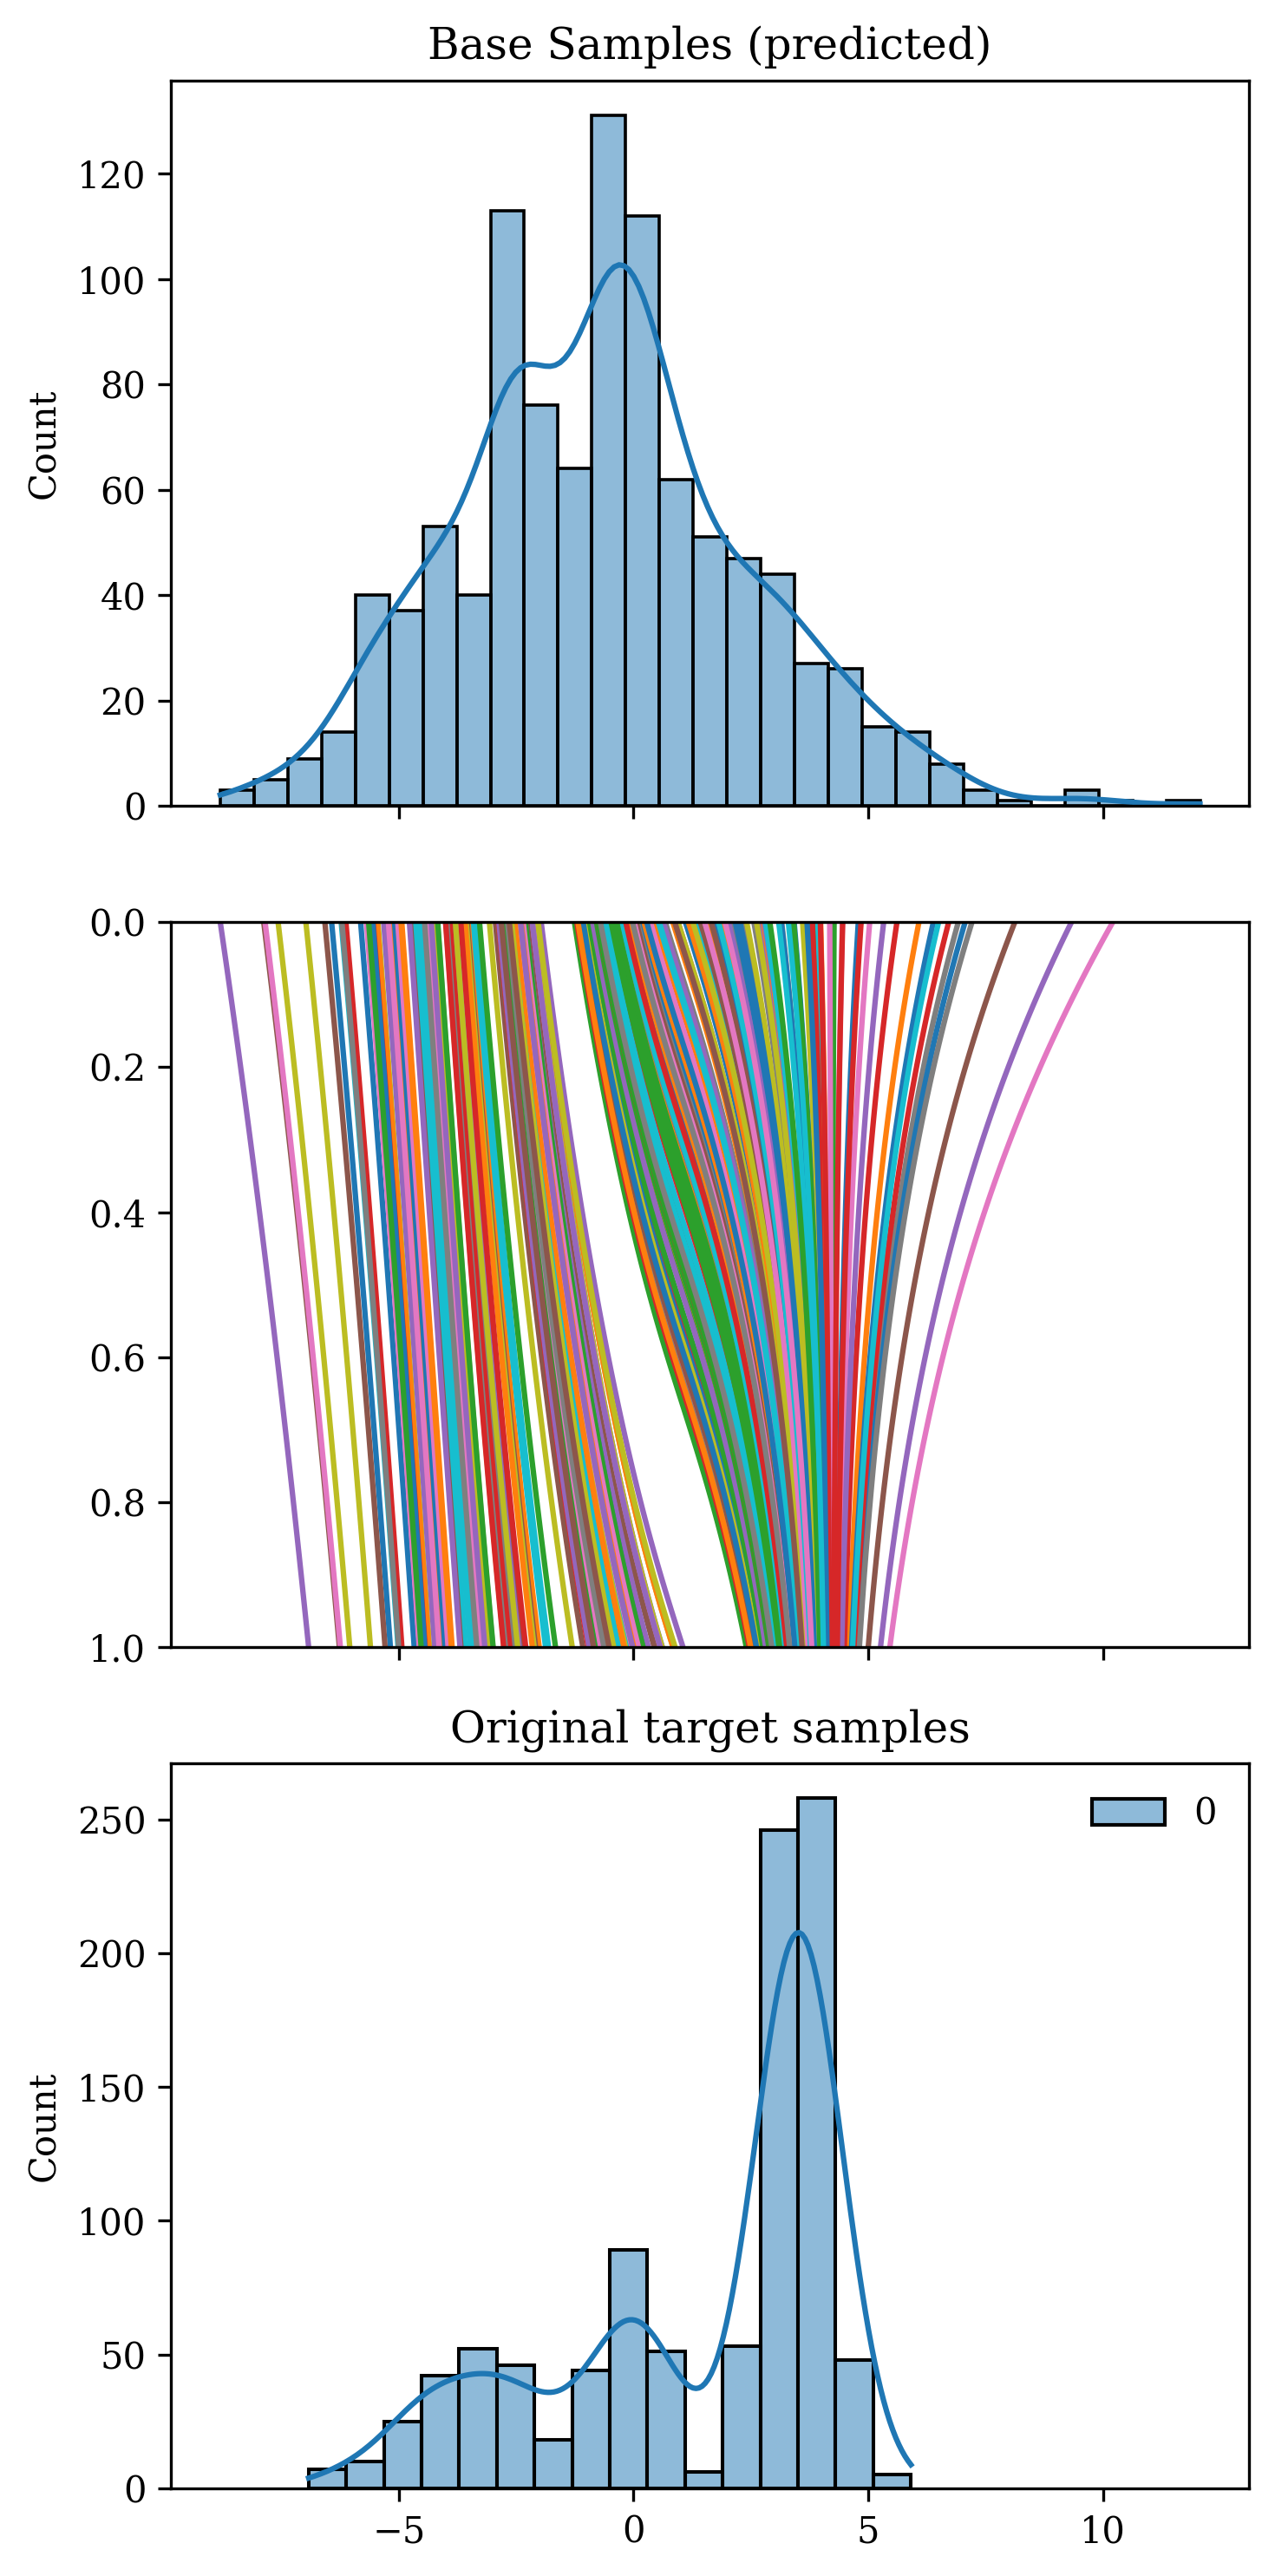

In [297]:
# PLOT BASE DISTRIBUTION i.e. p_z0.sample, LEARNT DYNAMICS i.e. z_t_final and TARGET DISTRIBUTION i.e. x IN A 3x1 PLOT WITH SEABORN

target_samples = xfinal.cpu().detach().numpy()
base_samples_actual = p_z0.sample((samples_pred, 1)).cpu().detach().numpy() # actually, we should use these and integrate in reverse, but never mind.
base_samples_predicted = z_t_final.cpu().detach().numpy()[-1, :, 0]

learnt_trajectories = z_t_final.cpu().detach().numpy()[:, :, 0]

fig, ax = plt.subplots(3, 1, figsize=(5, 10), sharex=True)

axs = ax.ravel()
sns.histplot(base_samples_predicted, ax=axs[0], kde=True, label="")
axs[0].set_title("Base Samples (predicted)")

traj_idx = np.random.choice(learnt_trajectories.shape[1], size=batch_pred, replace=False)



for i in traj_idx:
    axs[1].plot(learnt_trajectories[:, i], np.linspace(1, 0, time_pred), label='')

axs[1].set_ylim((1, 0))


sns.histplot(target_samples, ax=axs[2], kde=True, label="")
axs[2].set_title("Original target samples")

fig.tight_layout()